# DCGAN 

Ova sveska ima za cilj približavanje koncepata generativnih suparničkih mreža i jednog njihovog podtipa koji se (dugačko) naziva duboke konvolutivne generativne suparničke mreže (engl. Deep Convolutional Generative Adversarial Network, DCGAN). DCGAN ćemo primeniti u zadatku generisanje slika cifara nalik onima koje se nalaze u MNIST skupu podataka.  

Svaka generativna suparnička mreža (engl. Generative Adversarial Network, GAN) se sastoji od generatora i diskriminatora. Generator je neuronska mreža koja na osnovu nasumičnog ulaza treba da generiše što realnije izlaze, dok je diskriminator mreža koja treba da nauči da razlikuje izlaze generatora (lažne izlaze) od pravih podataka. Kako ćemo mi raditi na zadatku generisanja slika, generator bi trebalo da nauči da generiše što je moguće realnije slike cifara, a diskriminator bi trebao da nauči da klasifikuje slike na one koje su prave i one koje su lažne. <img src='assets/GAN_structure.png'>

### Treniranje diskriminatora:

Podaci nad kojima diskriminator uči dolaze iz dva izvora: sa jedne strane to su pravi podaci, a sa druge podaci koje generiše generator. Prave podatke diskriminator uzima kao pozitivne instance, a izlaze generatora kao negativne instance. Prilikom treniranja dikriminator prati svoju funkciju gubitka i ažurira parametre svoje mreže tako da je minimizuje. Dok se diskriminator trenira, generator se **ne trenira** već samo generiše slike koje su potrebne za obučavanje diskriminatora. 

### Treniranje generatora:

Generator uči na osnovu povratne informacije koju dobija od diskriminatora. Prilikom treniranja, prvo se za nasumičan ulaz koji prati neku raspodelu generiše odgovarajući izlaz generatora. Zatim se konsultuje diskriminator i prati njegov izlaz. Ovoga puta, uspešnost klasifikacije se ocenjuje koristeći funkciju gubitka generatora na osnovu koje se računaju gradijenti i propagiraju unazad kroz diskriminator i generator i ažuriraju parametri **samo** na nivou generatora. 

### Treniranje GAN mreže:

GAN mreža se trenira tako što se smenjuju treniranja diskriminatora i generatora. Prvo se jednu jednu epohu (ili više ephoa) trenira diskriminator, zatim se jednu epohu (ili više epoha) trenira generator, a zatim se ovi koraci smenjuju. 

Prvo ćemo učitati sve potrebne biblioteke.

In [2]:
from keras.datasets import mnist
from keras import layers
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from PIL import Image
from keras.optimizers import Adam

import matplotlib.pyplot as plt
import numpy as np

import sys
import os

Za vizuelizaciju progresa treniranja koristićemo biblioteku `tqdm`. Ova biblioteka omogućava fin prikaz *progress bar*-a. Biblioteka se može instalirati komandom `conda install -c conda-forge tqdm`, a više o scenarijima korišćenja može se pročitati na [zvaničnom sajtu](https://pypi.org/project/tqdm/). 

In [3]:
from tqdm import tqdm

In [ ]:
np.random.seed(7)

Slike koje će generator generisati čuvaćemo u direktorijumu sa imenom `images`. Stoga ćemo pre prvog pokretanja, obrisati i ponovo kreirati ovaj direktorijum.

In [4]:
!rm -rf images
!mkdir images

Pre nego li počnemo sa implementacijom uvešćemo još neke pojmove.

Generatorske mreže dobijaju na ulazu nasumičan vektor koji je obično potrebno transformisati u vektor većih dimenzija sa mnogo detalja. Zato se koriste operacije koje su po svom efektu suprotne od operacije agregacije koja se koristi u konvolutivnim neuronskim mrežama. 

Jedan način da se postigne ovo uvećanje dimenzije je korišćenje takozvane `upsampling` operacije koja ponavlja vrste i kolone matrice određeni broj puta. 
Na primer, za matricu 
$\begin{pmatrix}
1 & 2 \\
3 & 4 
\end{pmatrix}$
i faktor ponavljanja po vrstama i kolonama zapisan kompaktno (2, 2) odgovarajuća matrica je 
$\begin{pmatrix}
1 & 1 & 2 & 2\\
1 & 1 & 2 & 2\\
3 & 3 & 4 & 4\\
3 & 3 & 4 & 4
\end{pmatrix}$.

 U Keras biblioteci `upsampling` se postiže korišćenjem sloja `UpSampling2D`. 

Alternativni način povećanja dimenzije je uz korišćenje `transponovane konvolucije`. 
<img src='assets/transposed_convolution.png'> Na primer, za ulaz dimenzije 2x2, kernel dimenzije 2x2 i pomeraj (1, 1) dobija se matrica dimenzija 3x3 na način koji je opisan na slici. Za razliku od prethodne tehnike koja ponavlja vrednosti vrsta i kolona, ova tehnika može i da nauči kako da se popune polja nove veće matrice. 

Transponovana konvolucija je u Keras biblioteci podržana kroz sloj `Conv2DTranspose`.

Obe pomenute Keras funkcije imaju i neke svoje dodatne parametre kojima se može uticati na ponašanje.

U implementaciji DCGANa će biti korišćen i `BatchNormalization` sloj. Funkcija ovog sloja biće vršenje normalizacije vrednosti na način na koji smo to radili i korišćenjem standardnog skaliranja u pripremi podataka, a sa idejom da stabilizujemo i ubrzamo učenje. <img src='assets/batch_normalization.png'>

Poslednja napomena se odnosi se na funkcionalnu dimenziju Keras API-ja. Keras slojeve je moguće posmatrati i kao funkcije koje transformišu prosleđene im tenzore u nove tenzore. Ovakav način slaganja slojeva omogućava kreiranje modela koji imaju više ulaza (npr. video frejm i transkript koji ga prati), koji dele slojeve (na primer kod ugnježdenih reprezentacija reči) ili koji imaju više izlaza. 

Ako treba da kreiramo model koji odgovara potpuno povezanoj mreži koja na ulazu očekuje piksele slike čije su dimenzije 28x28, ima jedan skriveni sloj sa 100 neurona i izlaz dužine 10 kojim se prepoznaje cifra koja se nalazi na slici, to bi na način na koji smo do sada radili mogli da zapišemo ovako: 

In [6]:
model = Sequential()
model.add(Dense(100, input_shape=(28*28,), activation='relu'))
model.add(Dense(10, activation='softmax'))

Model koji koristi funkcionalni API se može posmatrati kao usmereni acklički graf. Početni čvor grafa se kreira  funkcijom `Input`, a svaki sledeći čvor se kreira pozivom neke od funkcije API-ja nad prethodnim čvorom (čvorovima). Model se kreira navođenjem prvog i poslednjeg čvora u grafu. 

Sledeći kod je ekvivalent prethodno napisanog koda. 

In [7]:
inputs = Input(shape = (28*28, ))
x = layers.Dense(100, activation='relu')(inputs)
outputs = layers.Dense(10, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs, name="mnist_model")

###  DCGAN implementacija

<img src='assets/DCGAN_original.png'>

Na slici je prikazana originalna arhitektura DCGAN generatora. Zbog računske zahtevnosti mi ćemo blago modifikovati ovu arhitekturu i prilagoditi je mogućnostima. Predlog je probati i sa pokretanjem ove implementacije u okviru [Google Colab](https://colab.research.google.com/notebooks/intro.ipynb) radnog okruženja koje stavlja na raspolaganje i korišćenje grafičkih kartica.

Klasa `DCGAN` koju ćemo napisati koristiće funkcionalnosti Keras biblioteke. Metode koje će biti podržane su:
- `__init__()`: inicijalizacija GAN mreže
- `build_generator()`: kreiranje generatorske mreže
- `build_discriminator()`: kreiranje diskriminatorske mreže 
- `train()`: treniranje GAN mreže
- `generate_img()`: generisanje jednog izlaza generatora 
- `save_imgs()`: čuvanje nekoliko izlaza generatora

In [8]:
class DCGAN():
    
    # Inicijalizacija parametara mreze 
    def __init__(self, latent_dim):
        
        # Slike sadržane u MNIST skupu su dimenzija 28x28 i crno bele su tj. sa jednim kanalom boja.
        # Stoga ćemo postaviti broj vrsta, broj kolona i broj kanala slike redom na 28, 28 i 1.
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        
        
        # Parametar latent_dim ce predstavljati dimenzionalnost latentnog prostora generatora.
        # To ce biti duzina vektora sa slucajnim vrednostima na osnovu kojeg generator generise slike cifara.
        self.latent_dim = latent_dim


        # Svojstvo discriminator će predstavljati diskriminatorski deo GAN mreže.
        # Diskriminator cemo kreirati pozivom funkcije build_discriminator().
        # Dodatno, ovako kreirani diskriminator cemo konfigurisati tako da koristi Adam optimizator, binarnu
        # unakrsnu entropiju kao funkciju greske i tacnost kao metriku.
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
                                   optimizer=Adam(0.0002, 0.5), 
                                   metrics=['accuracy'])

        # Svojstvo generator će predstavljati generatorski deo GAN mreže.
        # Gnerator cemo kreirati pozivom funkcije build_generator().
        self.generator = self.build_generator()
        
        
        # Svojstvo combined će predstavljati kombinovanu mrežu koja se sastoji od generatora i diskriminatora. 
        # Ovaj model cemo zapisati koriscenjem funkcionalnog API-ja.
        
        # Vektor z ce nam predstavljati ulaz u kombinovanu mrežu tj. slucajan ulaz generatora. 
        # U literaturi se cesto ovaj vektor naziva i šum (engl. noise).
        z = Input(shape=(self.latent_dim,))
        
        # Img će biti izlaz gneratora; njega racunamo na osnovu ulaza z  
        img = self.generator(z)

        # U kombinovanom modelu trenira se jedino generator. Zato ćemo postaviti trainable parametar diskriminator 
        # mreže na False vrednost. Trainable je binarni atribut sloja kojim se naglašava da li treba ažurirati 
        # koeficijente mreže kako bi se minimizovala funkcija gubitka.
        self.discriminator.trainable = False

        # U kombinovanom modelu diskriminator ce dati ocenu za generisanu i prosledjenu mu sliku.
        valid = self.discriminator(img)

        # Kombinovani model u celosti: ulaz je slucajan vektor z, a izlaz ocena diskriminatora. 
        # Dodatno cemo kompbinovanom modelu pridruziti Adam optimizator i binarnu unakrsnu entropiju kao funkciju greske.
        self.combined = Model(inputs=z, outputs=valid)
        self.combined.compile(loss='binary_crossentropy', 
                              optimizer=Adam(0.0002, 0.5))
        
     
    # Kreiranje generatorske mreze
    def build_generator(self, show_model_summary=True):

        # Generator je mreza koja od vektora dimenzije latent_dim treba da konstruise sliku dimenzija 28x28x1.
        # Prvo se latentni vektor mapira u vektor dimenzije 7x7x128 tj. u (7x7) x128 koji se upsampling tehnikom dalje
        # modifikuje na dimenziju 14x14x128. Zatim se konvolucijom uci kako da se popune polja novodobijene prosirene slike.
        # Zatim se vrsi batch normalizacija kako bi se pospesio protok gradijenata. Sldeca primena upsampling tehnike slike
        # dodatno modifikuje na dimenziju 28x28x128, konvolucija svodi na oblik 28x28x64 i opet uci da popuni polja novodobijene 
        # prosirene matrice, a batch normalizacija stabilizuje. 
        # Posledjim konvolutivnim slojem slika se transformise na dimenzije 28x28x1, a hiperbolicka aktivacija vrednosti
        # svodi na opseg [-1, 1]. 

        model = Sequential()
        model.add(Dense(128 * 7 * 7, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((7, 7, 128)))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(Conv2D(self.channels, kernel_size=3, padding="same"))
        model.add(Activation("tanh"))

        if show_model_summary:
            print('Generator summary:')
            model.summary()
            
        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    # Kreiranje diskriminatorske mreze
    def build_discriminator(self, show_model_summary=True):

        # Diskriminator je mreza koja klasifikuje slike na prave i lazne.

        model = Sequential()
        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))
        
        if show_model_summary:
            print('Discriminator summary:')
            model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    
    # Treniranje GAN-a
    # argumenti funkcije su:
    # broj epoha treniranja
    # velicina paketica koji se koriste u treniranju
    # broj koji oznacava periodu cuvanja izlaznih slika diskriminatora zbog uvida u uspesnost treniranja  
    def train(self, epochs, batch_size=128, save_interval=50):

        # Ucitavamo MNIST skup podataka.
        # Zainteresovani smo samo za slike koje se nalaze u skupu za treniranje. 
        (X_train, _), (_, _) = mnist.load_data()

        # Slike cemo modifikovati tako da pojedinacne vrednosti piksela koje su iz intervala [0, 255]
        # budu iz opsega [-1, 1].
        X_train = X_train / 127.5 - 1
        X_train = np.expand_dims(X_train, axis=3)

        # Mreza ce se trenirati u paketicima velicine batch_size i to tako sto ce joj se prvo zadavati
        # batch_size pravih slika, a zatim batch_size laznih slika. 
        # U prvom slucaju izlaz mreze treba da bude vektor jedinica duzine batch_size, a u drugom vektor nula 
        # takodje duzine batch_size. Te vektore, redom, predstavljaju promenljive valid i fake.
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        
        # Prilikom treniranja praticemo i vrednosti funkcije gubitka generatora i diskriminatora. 
        g_losses = np.ones((epochs))
        d_losses = np.ones((epochs))
        
        # Praticemo i vrednosti tacnosti diskriminatora. 
        d_acc = np.ones((epochs))

        
        # Za svaku epohu, radimo sledece:
        for epoch in tqdm(range(epochs)):

            # ----------------------------
            #  Treniramo diskriminator
            # ----------------------------

            # Biramo nasumicno batch_size pravih slika
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            # Generisemo nasumicno batch_size vektora na osnovu kojih generator treba da generise lazne slike.
            # Ove vektore generisemo iz normalne raspodele N(0, 1)
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise)

            # Treniramo diskriminator:
            # 1) za prave slike koristimo vektor valid koji sadrzi jedinice kao ocekivane vrednosti izlaza
            # 2) za lazne slike koristimo vektor fake koji sadrzi nule kao ocekivane vrednosti izlaza
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            
            # Izracunavamo gresku diskriminatora kao aritmeticku sredinu greske na pravim i laznim slikama.
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            
            # Belezimo dobijenu vrednosti funkcije gubita i dobijenu tacnost.
            d_losses[epoch] = d_loss[0]
            d_acc[epoch] = d_loss[1]
            
            
            # ------------------------
            #  Treniramo generator
            # ------------------------

            # Pratimo kako se ponasa generator. Zbog prirode rada generatora train_on_batch pozivamo na nivou 
            # kombinovanog modela.
            g_loss = self.combined.train_on_batch(noise, valid)
            
            # Belezimo gresku generatora.
            g_losses[epoch] = g_loss
            

            # Ukoliko smo u naglasenoj iteraciji, cuvamo nekoliko generisanih slika generatora.
            if epoch % save_interval == 0:
                self.save_imgs(epoch)
                
        # Kao rezultat vracamo nizove sa vrednostima funkcije gubitka i tacnosti.
        return d_losses, g_losses, d_acc


    # Funkcija kojom generator generise sliku za zadati proizvoljni ulaz z
    def generate_img(self, z):
        
        # Generisemo sliku.
        gen_img = self.generator.predict(z)
        
        # Generisana slika ima piskele koji su u opsegu [-1, 1]
        # Radimo reskaliranje na interval [0, 1]
        gen_img = 0.5 * gen_img + 0.5
        
        # Vracamo matricu ovako generisane slike.
        return gen_img

    
    # Funkcija kojom cuvamo nasumicne slike koje generise generator na kraju zadate epohe
    def save_imgs(self, epoch):
        
        # Generisacemo ukupno 5 x 5 slicica generatora 
        # r ce oznacavati vrstu u ovoj matrici slika, a c kolonu
        r, c = 5, 5

        # Generisemo r x c nasumicnih ulaza za generator, a na osnovu njih i r x c slika
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generate_img(noise)

        # svaku generisanu sliku cemo sada smestiti na odgovarajuce mesto u matrici slika i sacuvati je
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images/mnist_%d.png" % epoch)
        plt.close()

In [9]:
dcgan = DCGAN(latent_dim=100)

Discriminator summary:
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 8, 8, 64)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 64)          256       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (N

Mrežu ćemo trenirati koristeći dole navedene parametre. Samo treniranje mreže, u zavisnosti od kapaciteta računara,  može da potraje (oko sat vremena).

In [10]:
epochs = 2000
batch_size = 32
save_interval = 50

In [11]:
d_losses, g_losses, d_acc = dcgan.train(epochs=epochs, batch_size=batch_size, save_interval=save_interval)

  0%|          | 0/2000 [00:00<?, ?it/s]

Instructions for updating:
Use tf.cast instead.


/opt/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
100%|██████████| 2000/2000 [36:37<00:00,  1.10s/it]


Nakon treniranja ćemo sačuvati naučene modele. 

In [20]:
dcgan.generator.save('models/generator.h5')
dcgan.discriminator.save('models/discriminator.h5')
dcgan.combined.save('models/gan_combined.h5')

Dalje želimo da proverimo kako izgleda nekoliko poslednjih slika koje je DCGAN generisao. Nije loše! :)

In [12]:
imgs = os.listdir('images')
imgs.sort(key=lambda x: int(x.split('_')[1].split('.')[0]))

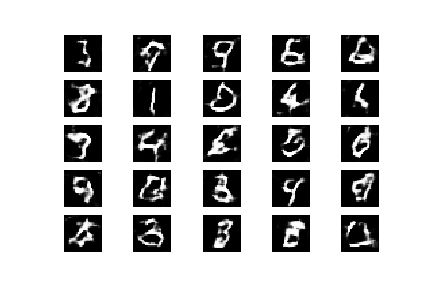

In [13]:
the_img = Image.open(os.path.join('images', imgs[-10]))
the_img

Funkcija `show_losses` će nam prikazati kako su izgledale funkcije gubitka za genrator i diskriminator u toku treniranja.

In [14]:
def show_loss(d_losses, g_losses):
    plt.figure(figsize=(20,10))
    plt.plot(range(epochs), d_losses, label='Discriminator loss')
    plt.plot(range(epochs), g_losses, label='Generator loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='best')

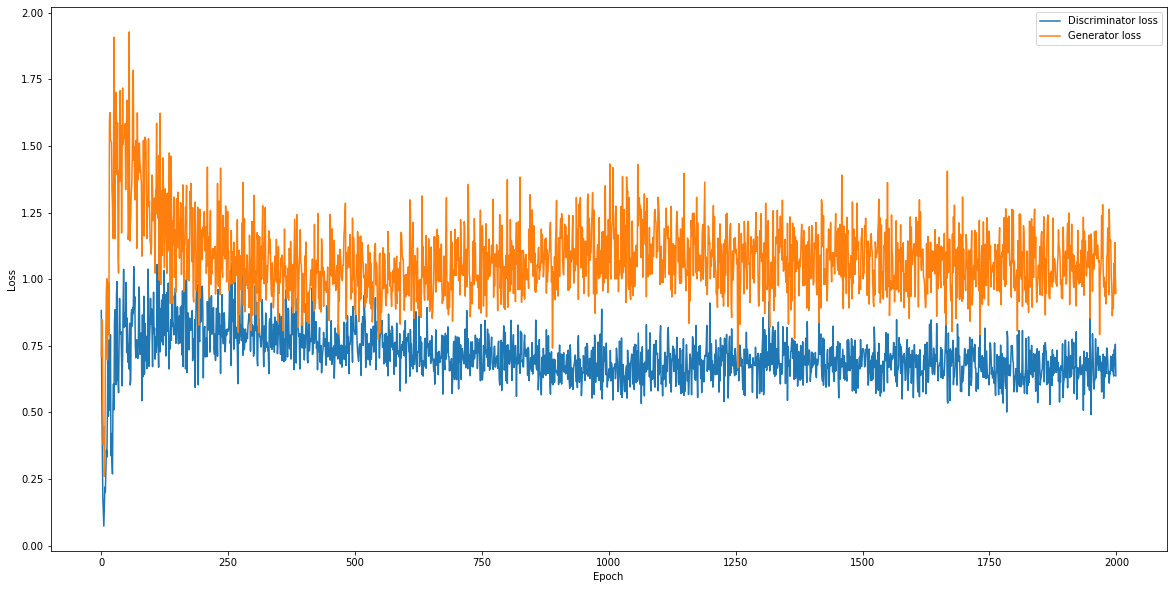

In [15]:
show_loss(d_losses, g_losses)

Funkcija `show_acc` će nam prikazati kako se menjala tačnost diskriminatora u toku treniranja.

In [16]:
def show_acc(d_acc):
    plt.figure(figsize=(20,10))
    plt.plot(range(epochs), d_acc)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')    

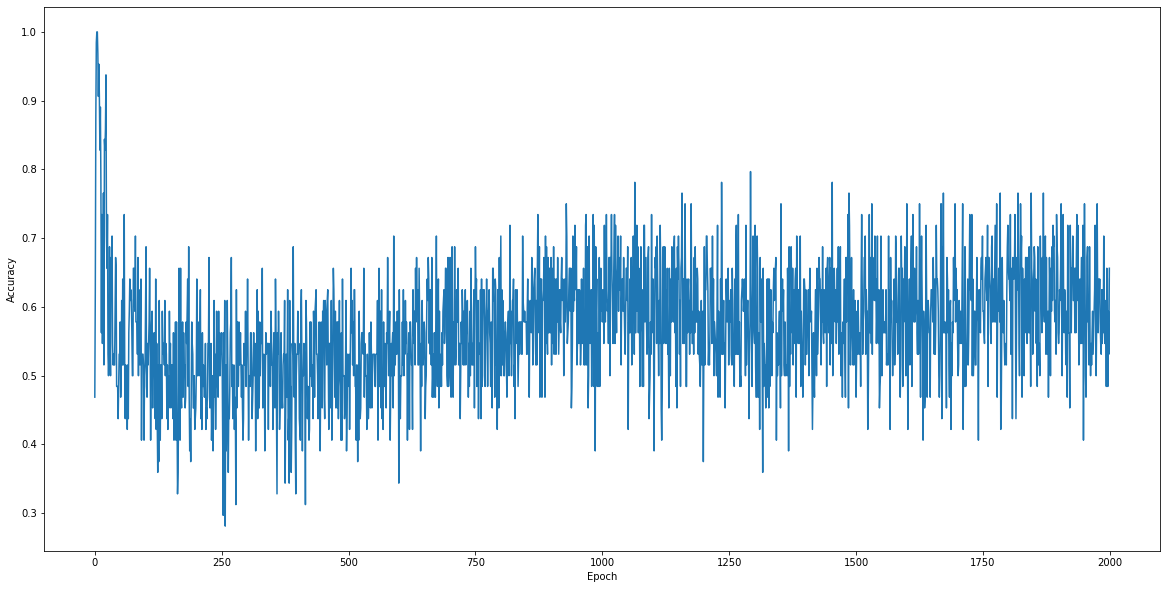

In [17]:
show_acc(d_acc)

Ako u toku treniranja generator uči da generiše dobre slike, diskriminatoru postaje teško da razlikuje lažne od pravih. Zato njegove performanse opadaju i u idealnom scenariju diskriminator ima 50% šanse da pogodi koja je slika prava, a koja lažna.

Korišćenje našeg modela je moguće kroz funkciju `generate_img`. Dovoljno je zadati neki proizvoljan vektor kao ulaz.

In [18]:
z = np.random.normal(0, 1, (1, dcgan.latent_dim))
img = dcgan.generate_img(z)
img = np.squeeze(img)
print(img.shape)

(28, 28)


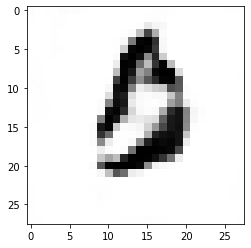

In [19]:
plt.imshow(img, cmap='Greys')

<div class='alert alert-info'>
    Materijali za pogledati: 
    <a href='https://arxiv.org/pdf/1511.06434.pdf' target='_balnk'> Originalni rad DCGAN </a>
</div>

<div class='alert alert-success'>
    Zadaci za vežbu:   
    <ul>
       <li>Šta će se desiti ukoliko dimenzionalnost latentnog prostora spustimo na vrlo nizak broj, na primer 2?</li>
        <li>Da li može da obučite GAN tako da radi iole dobro za tako mali latentni prostor?</li>
        <li>Ako uspete, da li primećujete neko pravilo kada vektoru latentnog prostora varirate samo jednu koordinatu?
        </li>
        <li> Sa <a href='https://drive.google.com/file/d/1jdJXkQIWVGOeb0XJIXE3YuZQeiEPd8rM/view'> ove adrese </a> možete preuzeti sličice anime avatara. Isprobajte kako DCGAN radi sa ovim skupom. Avatari su nešto drugačijih dimenzija i koriste 3 kanala boja pa je ulazne parametre mreže potrebno prilagoditi. Diskriminator može ostati isti, a u generatoru se može krenuti od mapiranja u gusti sloj dimenzije 128x16x16 tj. (16x16)x128. </li> 
</div>

<div class='alert alert-danger'>
Primer je prilagodjena verzija DCGANa iz knjige:
    <br>
    Amita Kapoor, Antonio Gulli, Sujit Pal: Deep Learning with TensorFlow 2 and Keras: Regression, ConvNets, GANs, RNNs, NLP, and more with TensorFlow 2 and the Keras API, 2nd Edition 
</div>